# Load

In [1]:
import io
import logging
import math
import sys
import pandas as pd
from typing import get_args
from py_ballisticcalc import Ammo, Vacuum, Shot, Calculator, HitResult
from py_ballisticcalc import BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG1, logger
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire
from py_ballisticcalc.unit import *
from py_ballisticcalc.interface import _EngineLoader
logger.setLevel(logging.WARNING)
print("\nAvailable engines: " + str(sorted([e.name for e in _EngineLoader.iter_engines()])))
PreferredUnits.drop = Distance.Feet
PreferredUnits.distance = Distance.Feet


Available engines: ['cythonized_euler_engine', 'cythonized_rk4_engine', 'euler_engine', 'rk4_engine', 'scipy_engine', 'verlet_engine']


# Vacuum Trajectory

Here is a convenient vacuum scenario so that we can check engine precision against a known exact solution.  A vacuum ballistic trajectory is a simple parabola, but the integration engines don't know that, so they attack it as they would even the most complicated ballistic scenario.

This trajectory returns to ground level after exactly 60 seconds.  We will ask the engines to return the trajectory at exactly that time, and **define the error as the distance from the correct point** (x = range_to_zero, y = 0).

In [2]:
from py_ballisticcalc.helpers import vacuum_velocity_to_zero, vacuum_time_to_zero, vacuum_range
cGravityConstant: float = -32.17405  # feet per second^2
launch_angle_deg = 30.0
launch_angle_rad = math.radians(launch_angle_deg)
time_to_zero = 60.0  # seconds
launch_velocity_fps = vacuum_velocity_to_zero(time_to_zero=time_to_zero, launch_angle_deg=launch_angle_deg, gravity=-cGravityConstant)
time = vacuum_time_to_zero(velocity=launch_velocity_fps, launch_angle_deg=launch_angle_deg, gravity=-cGravityConstant)
range_to_zero = vacuum_range(velocity=launch_velocity_fps, angle_in_degrees=launch_angle_deg, gravity=-cGravityConstant)
print(f'{time} seconds to return to zero, launching at {launch_velocity_fps}fps with {launch_angle_deg} degrees.  '
      f'Range={range_to_zero:.4f}ft.')

shot = Shot(ammo=Ammo(DragModel(bc=0.759, drag_table=TableG1), Velocity.FPS(launch_velocity_fps)), atmo=Vacuum())
shot.relative_angle = Angular.Degree(launch_angle_deg)

def check_error(hit: HitResult, output: bool = False) -> float:
    chkpt = hit.get_at_time(60.0)
    if chkpt is not None:
        chk_x = chkpt.distance >> Distance.Feet
        chk_h = chkpt.height >> Distance.Feet
        chk_err = math.sqrt((chk_x-range_to_zero)**2 + chk_h**2)
        if output:
            print(f'At {chkpt.time}s: ({chk_x}, {chk_h})ft ==> Error = {chk_err:.8f}ft')
        return chk_err
    return float('inf')

summary = []

60.0 seconds to return to zero, launching at 1930.4430000000002fps with 30.0 degrees.  Range=100308.7607ft.


# SciPy

Here's a simple example to show what we're working with:

In [3]:
config = SciPyEngineConfigDict(
    cMinimumAltitude=-1,
    integration_method="LSODA",
)
calc = Calculator(config, engine='scipy_engine')
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), extra_data=True, time_step=60.0)
check_error(hit, True)
hit.dataframe(True).drop(columns=['windage', 'slant_height', 'drop_angle', 'windage', 'windage_angle', 'slant_distance', 'density_ratio', 'drag', 'energy', 'ogw'])

At 59.9999999999988s: (100308.7607134686, 1.3404160230204362e-12)ft ==> Error = 0.00000000ft


,time,distance,velocity,mach,height,angle,flag
0,0.000 s,0.00 ft,1930.4 ft/s,1.73 mach,0.00 ft,30.0000 °,ZERO_UP|RANGE
1,30.000 s,50154.38 ft,1671.8 ft/s,1.58 mach,14478.32 ft,0.0000 °,APEX
2,60.000 s,100308.76 ft,1930.4 ft/s,1.73 mach,0.00 ft,-30.0000 °,ZERO_DOWN|RANGE


Here's the function we'll use to test the `SciPyIntegrationEngine`:

In [4]:
def scipy_chk(timeit: bool = False, **kwargs):
    config = SciPyEngineConfigDict(
        cMinimumAltitude=-1,
        **kwargs,
    )
    calc = Calculator(config, engine='scipy_engine')
    t = calc.fire(shot, Distance.Feet(range_to_zero), time_step=60.0)
    err = check_error(t, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o calc.fire(shot, Distance.Feet(range_to_zero), time_step=60.0)
        return err, evals, speed.average
    return err, evals
err, count, speed = scipy_chk(timeit=True, integration_method="LSODA")
print(f'Error={err:.8f}ft.  Integration steps: {calc.integration_step_count}.  Speed: {speed:.5f}s')

1.72 ms ± 76.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Error=0.00000000ft.  Integration steps: 16.  Speed: 0.00172s


### Integration Methods

Here's a quick look at each of the integration methods listed in the SciPyIntegrationEngine, using its default error tolerance settings.

In [5]:
from py_ballisticcalc.engines.scipy_engine import INTEGRATION_METHOD
stdout = sys.stdout  # Capture stdout because timeit prints to it
sys.stdout = io.StringIO()
for method in get_args(INTEGRATION_METHOD):
    err, count, speed = scipy_chk(timeit=True, integration_method=method)
    summary.append(('SciPy', method, err, count, speed))
sys.stdout = stdout
pd.DataFrame(summary, columns=['Engine', 'Setting', 'Error (ft)', 'Integration Steps', 'Speed']).sort_values(by='Speed', ascending=True)

,Engine,Setting,Error (ft),Integration Steps,Speed
5,SciPy,LSODA,1.154649e-09,16,0.001495
0,SciPy,RK23,1.091394e-11,23,0.001797
1,SciPy,RK45,5.823608e-11,32,0.001822
2,SciPy,DOP853,1.091394e-10,77,0.002812
3,SciPy,Radau,1.818989e-11,53,0.003684
4,SciPy,BDF,1.088265e-07,58,0.007764


### Points computed

We can actually look at the points evaluated by SciPy: Uncomment `diff_eq()::self.eval_points.append(t)` in `scipy_engine.py`.  We'll see something interesting when we use LSODA: It appears that it is evaluating the first two steps *twice*.

We must remember that the function being solved is not just `f(t)`, but `f(t, s)`, where `s` is the state vector `[x, y, z, vx, vy, vz]`.

**Even if the time `t` is identical, the state `s` is different.**

Here are the primary reasons why a solver like LSODA would evaluate `f(t, s)` with the same `t` but a different `s`:

1.  **Jacobian Calculation (for Stiff Problems):** LSODA can switch to a stiff solver (BDF). To do this, it needs to compute the Jacobian matrix, which tells it how the derivative changes with respect to the state (`df/ds`). It computes this numerically by slightly perturbing each component of the state vector `s` and re-evaluating the function. All of these evaluations happen at the *same time `t`* but with slightly different state vectors `s`.

2.  **Error Estimation:** Some adaptive methods (though more common in Runge-Kutta methods) estimate the error by comparing the results of two different calculations that end at the same time `t`. This inherently requires multiple evaluations at intermediate points that can sometimes coincide in time.

3.  **Corrector Iterations (for Stiff Solvers):** Stiff solvers often use a "predictor-corrector" method. They predict a new state and then iterate to "correct" it until it converges. These correction iterations all happen at the same future time point `t`, but the state `s` is refined with each iteration, requiring a new function evaluation.

In [6]:
config = SciPyEngineConfigDict(
    cMinimumAltitude=-1,
    relative_tolerance=1e-12,
    absolute_tolerance=1e-8,
    integration_method="LSODA",
)
calc = Calculator(config, engine='scipy_engine')
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), time_step=60.0)
calc.eval_points  # Uncomment diff_eq()::self.eval_points.append(t) in scipy_engine.py to see eval points

[0.0,
 5.968364397369551e-06,
 5.968364397369551e-06,
 1.1936728794739102e-05,
 1.1936728794739102e-05,
 0.059695580702490245,
 0.11937922467618575,
 0.17906286864988125,
 0.7758993083868364,
 1.3727357481237914,
 1.9695721878607464,
 7.937936585230297,
 13.906300982599848,
 19.8746653799694,
 79.55830935366491]

### Tolerance

The SciPy solver works until it satisfies the least demanding error tolerance (between _relative_ and _absolute_). The most demanding error tolerance is just over 1e-14 (a value based on the limits of _float_ precision).  As we can see in the results from the next block: with relative tolerance set near the maximum, the absolute tolerance (`atol`) doesn't require more steps to reduce error until `atol < 1e-8`.

In [7]:
results = []
method = 'RK45'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-10
while rtol > 1e-10:
    rtol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    results.append((atol, rtol, err, count))
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-12
while atol > 1e-10:
    atol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    results.append((atol, rtol, err, count))
pd.DataFrame(results, columns=['Absolute Tolerance', 'Relative Tolerance', 'Error (ft)', 'Integration Steps'])

,Absolute Tolerance,Relative Tolerance,Error (ft),Integration Steps
0,1.000000e-10,1.000000e-02,4.729372e-11,86
1,1.000000e-10,1.000000e-03,1.001973e-10,80
2,1.000000e-10,1.000000e-04,4.688090e-11,74
3,1.000000e-10,1.000000e-05,7.730705e-11,68
4,1.000000e-10,1.000000e-06,6.821210e-11,62
5,1.000000e-10,1.000000e-07,1.155166e-10,56
6,1.000000e-10,1.000000e-08,4.092726e-11,50
7,1.000000e-10,1.000000e-09,6.442022e-11,44
8,1.000000e-10,1.000000e-10,7.912604e-11,38
9,1.000000e-10,1.000000e-11,3.637979e-11,38


But something counterintuitive is going on: In this test when we fix `atol=1e-10` we observe that the solver uses _fewer_ function evaluations as `rtol` _decreases_ from 1e-2 to 1e-10.  In general, decreasing `rtol` (holding all else constant) demands more precision from the solver and so should force the solver to take smaller steps, thus _increasing_ the number of function evaluations.

Here’s a breakdown of what is likely happening:

#### The Interaction of Tolerances and Step-Size Control

The solver's goal at each step is to keep the estimated local error (`err_est`) below a threshold:

`err_est <= atol + rtol * |y|`

It then uses this relationship to decide the size of the *next* step. A simplified view of the logic is:

1.  Take a trial step.
2.  Estimate the error `err_est`.
3.  If the error is too large, reject the step, shrink the step size, and try again.
4.  If the error is acceptable, accept the step.
5.  Calculate an "optimal" size for the *next* step based on the error from the current one. The goal is to make the next step as large as possible while still meeting the tolerance.

#### The Counter-Intuitive Behavior Here

In this experiment, `atol` is fixed at a very small `1e-10`.

1.  **When `rtol` is large (e.g., `1e-2`):**
    *   The total allowed error (`atol + rtol * |y|`) is quite large and dominated by the `rtol` term.
    *   The solver's step-size controller is encouraged to take very large steps.
    *   It might "overshoot" significantly, trying a huge step. The error estimate for this large step will also be large. The controller might then have to reject the step and retry with a smaller one. This process of trying a big step, failing, and retrying with smaller steps can lead to a higher total number of function evaluations.

2.  **When `rtol` is smaller (e.g., `1e-8`):**
    *   The total allowed error is now much smaller.
    *   The step-size controller is immediately more conservative. It doesn't even *attempt* the huge, optimistic steps it tried before.
    *   It starts with and continues to propose more reasonably sized steps. Because these steps are more likely to be accepted on the first try (without rejection), the total number of function evaluations can actually go down.

Here we are essentially seeing a transition from a "sloppy and aggressive" strategy to a "cautious and efficient" one.

| `rtol` | Solver Strategy | Step Rejections | Function Evaluations |
| :--- | :--- | :--- | :--- |
| **Large** | Tries very large, optimistic steps. | High (many steps are rejected and retried) | **Higher** |
| **Small** | Tries smaller, more conservative steps. | Low (most steps are accepted on first try) | **Lower** |

This is not a universal rule and is highly dependent on the specific solver (`RK45` in this case), the smoothness of the problem (a vacuum trajectory is extremely smooth), and the specific values of `atol` and `rtol`.

We can inspect the actual points being attempted to confirm that this is what's happening here:

In [8]:
# *** THIS WILL NOT WORK unless you uncomment diff_eq()::self.eval_points.append(t) in scipy_engine.py ***
#region "strict" setup
config = SciPyEngineConfigDict(
    cMinimumAltitude=-1,
    relative_tolerance=1e-10,
    absolute_tolerance=1e-10,
    integration_method="RK45",
)
calc = Calculator(config, engine='scipy_engine')
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), time_step=60.0)
strict_eval_times = calc.eval_points
print(f'"Strict" rtol=1e-10 made {len(strict_eval_times)} evaluations.')
#endregion
#region "sloppy" setup
config = SciPyEngineConfigDict(
    cMinimumAltitude=-1,
    relative_tolerance=1e-2,
    absolute_tolerance=1e-10,
    integration_method="RK45",
)
calc = Calculator(config, engine='scipy_engine')
hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), time_step=60.0)
sloppy_eval_times = calc.eval_points
print(f'"Sloppy" rtol=1e-02 made {len(sloppy_eval_times)} evaluations.')
#endregion
import numpy as np
# Look for evidence of retries: small forward steps in time
strict_diffs = np.diff(strict_eval_times)
sloppy_diffs = np.diff(sloppy_eval_times)
print(f"\nSmallest time step with strict rtol: {np.min(strict_diffs[strict_diffs > 0]):.2e} s")
print(f"Smallest time step with sloppy rtol: {np.min(sloppy_diffs[sloppy_diffs > 0]):.2e} s")
# A rejected step often involves re-evaluating at the same or a very close time point.
# Let's count how many time steps are extremely small, indicating a retry.
print(f"\nApparent retries (dt < 1e-5s) with strict rtol: {np.sum(strict_diffs < 1e-5)}")
strict_eval_times = np.asarray(strict_eval_times)
print(f'\t Strict evals within first microsecond: {np.sum(strict_eval_times < 1e-6)}')
print(f"Apparent retries (dt < 1e-5s) with sloppy rtol: {np.sum(sloppy_diffs < 1e-5)}")
sloppy_eval_times = np.asarray(sloppy_eval_times)
print(f'\t Sloppy evals within first microsecond: {np.sum(sloppy_eval_times < 1e-6)}')

"Strict" rtol=1e-10 made 38 evaluations.
"Sloppy" rtol=1e-02 made 86 evaluations.

Smallest time step with strict rtol: 7.32e-06 s
Smallest time step with sloppy rtol: 7.33e-14 s

Apparent retries (dt < 1e-5s) with strict rtol: 7
	 Strict evals within first microsecond: 1
Apparent retries (dt < 1e-5s) with sloppy rtol: 53
	 Sloppy evals within first microsecond: 38


The following chart shows that in the end this algorithm sampled virtually the same points.  It's just that the "sloppy" approach hit points within the first microsecond of the trajectory 38 times!

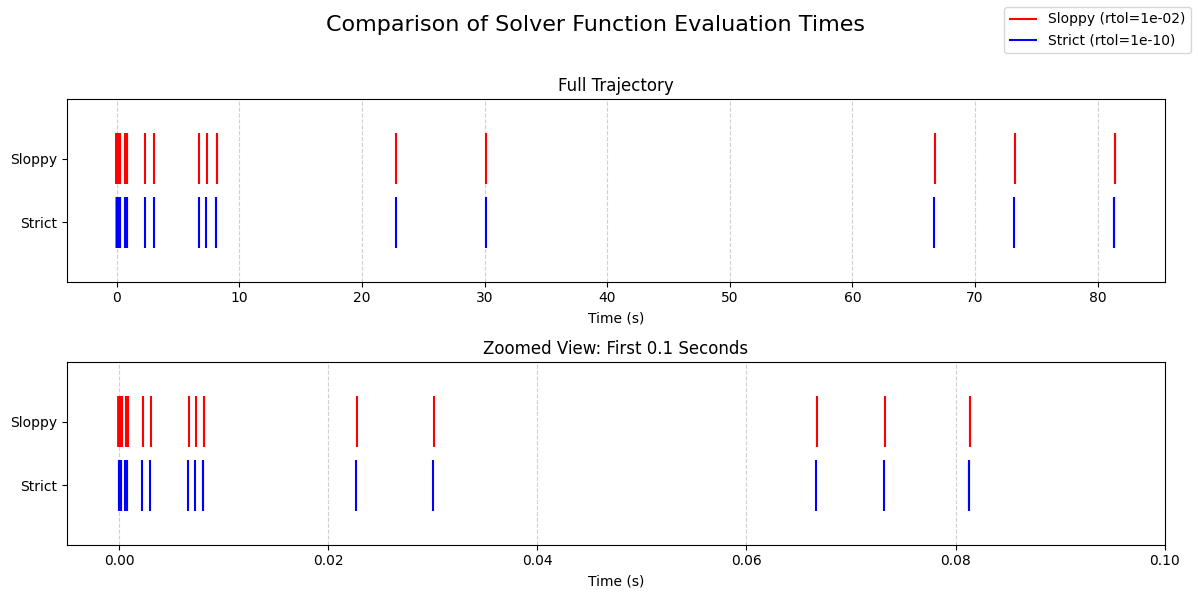

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
fig.suptitle('Comparison of Solver Function Evaluation Times', fontsize=16)
# --- Plot 1: Full Trajectory ---
ax1.eventplot(sloppy_eval_times, lineoffsets=1, colors='red', label='Sloppy (rtol=1e-02)', linelengths=0.8)
ax1.eventplot(strict_eval_times, lineoffsets=0, colors='blue', label='Strict (rtol=1e-10)', linelengths=0.8)
ax1.set_title('Full Trajectory')
ax1.set_xlabel('Time (s)')
ax1.grid(axis='x', linestyle='--', alpha=0.6)
# --- Plot 2: Zoomed-in on the start ---
ax2.eventplot(sloppy_eval_times, lineoffsets=1, colors='red', linelengths=0.8)
ax2.eventplot(strict_eval_times, lineoffsets=0, colors='blue', linelengths=0.8)
ax2.set_title('Zoomed View: First 0.1 Seconds')
ax2.set_xlabel('Time (s)')
ax2.set_xlim(-0.005, 0.1)
ax2.grid(axis='x', linestyle='--', alpha=0.6)
# --- Formatting ---
plt.yticks([0, 1], ['Strict', 'Sloppy'])  # Set shared y-axis labels
fig.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
plt.show()

# Other engines

The simplistic Euler engine sets the time-step size for each iteration based on a constant distance-like `DEFAULT_STEP` setting that is normalized by the projectile's velocity at the beginning of each step.  This makes it take smaller steps when the projectile is moving fast, and larger steps when it is slower.  The effect is to create roughly constant distance steps over the trajectory.

The RK4 and Verlet engines use a constant `DEFAULT_TIME_STEP`.

For all three engines we can change their speed and step sizes using the `cStepMultiplier` config setting.

Following is the function we'll use to check these engines:

In [10]:
def vacuum_chk(engine_name: str, timeit: bool = False, step_multiplier: float = 1.0, min_altitude: float = -1.0):
    config = BaseEngineConfigDict(
        cMinimumAltitude=min_altitude,
        cStepMultiplier=step_multiplier,
    )
    calc = Calculator(config, engine=engine_name)
    hit, e = must_fire(calc, shot, Distance.Feet(range_to_zero), time_step=60.0)
    err = check_error(hit, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot, Distance.Feet(range_to_zero), time_step=60.0)
        return err, evals, speed.average
    return err, evals

## Euler steps

In [11]:
step = 5.0
multiplier = 1.0/step
while multiplier <= 1000.0:
    err, count, speed = vacuum_chk('euler_engine', timeit=True, step_multiplier=multiplier, min_altitude=-1000.0)
    summary.append(('Euler', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (ft)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Euler']

10.1 s ± 434 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.96 s ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
385 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80.4 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.4 ms ± 644 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.22 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,Multiplier,Error (ft),Integration Steps,Speed
6,Euler,0.2,0.054931,1056316,10.145724
7,Euler,1.0,0.274653,211265,1.963174
8,Euler,5.0,1.373272,42254,0.385004
9,Euler,25.0,6.866495,8452,0.080411
10,Euler,125.0,34.333201,1692,0.016355
11,Euler,625.0,171.666727,340,0.004216


## RK4

In [12]:
vacuum_chk('rk4_engine', timeit=True, step_multiplier=1000.0)

1.42 ms ± 26.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


(3.17464884975649e-11, 41, 0.001415420871423391)

In [13]:
step = 5.0
while step <= 5000.0:
    err, count, speed = vacuum_chk('rk4_engine', timeit=True, step_multiplier=step)
    summary.append(('RK4', step, err, count, speed))
    step *= 5.0
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (ft)', 'Integration Steps', 'Speed'])
df[df.Engine == 'RK4']

235 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.5 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.7 ms ± 140 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.08 ms ± 58.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
552 μs ± 18.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (ft),Integration Steps,Speed
12,RK4,5.0,6.457498e-09,8001,0.235167
13,RK4,25.0,3.176930e-09,1601,0.047537
14,RK4,125.0,2.562459e-10,321,0.009695
15,RK4,625.0,5.815080e-11,65,0.002079
16,RK4,3125.0,5.655595e+01,13,0.000552


## Verlet

In [14]:
step = 5.0
while step <= 5000.0:
    err, count, speed = vacuum_chk('verlet_engine', timeit=True, step_multiplier=step)
    summary.append(('Verlet', step, err, count, speed))
    step *= 5.0
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (ft)', 'Integration Steps', 'Speed'])
df[df.Engine == 'Verlet']

149 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.5 ms ± 654 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.61 ms ± 563 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.36 ms ± 21.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
426 μs ± 38.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (ft),Integration Steps,Speed
17,Verlet,5.0,1.100426e-08,12001,0.148593
18,Verlet,25.0,2.611067e-09,2401,0.029496
19,Verlet,125.0,2.098737e-10,481,0.006610
20,Verlet,625.0,3.399236e-11,97,0.001359
21,Verlet,3125.0,2.513598e+01,20,0.000426


# Summary

All of the higher-order engines can fit this parabola with fewer than 100 function evaluations.  Only the simplistic Euler engine struggles to approximate it, carrying a measurable error even with hundreds of thousands of steps.

In [15]:
display(df.style.format({'Error (ft)': '{:.12f}'}))

,Engine,Multiplier,Error (ft),Integration Steps,Speed
0,SciPy,RK23,0.000000000011,23,0.001797
1,SciPy,RK45,0.000000000058,32,0.001822
2,SciPy,DOP853,0.000000000109,77,0.002812
3,SciPy,Radau,0.000000000018,53,0.003684
4,SciPy,BDF,0.000000108826,58,0.007764
5,SciPy,LSODA,0.000000001155,16,0.001495
6,Euler,0.200000,0.054930622434,1056316,10.145724
7,Euler,1.000000,0.274653115431,211265,1.963174
8,Euler,5.000000,1.373271879239,42254,0.385004
9,Euler,25.000000,6.866495202007,8452,0.080411
